# Сборный проект. Выявления закономерностей успешности игр.

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Нужно отработать принцип работы с данными. 
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Проверим датафрейм на дубликаты:

In [6]:
data.duplicated().sum()

0

### Вывод

В датафрейме встречается верблюжий регистр. В столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Raiting встречаются пропуски. Столбцы User_Score, Year_of_Release имеют неверный тип данных.

## Предобработка данных

Приведем названия столбцов к нижнему регистру:

In [7]:
data = data.rename(columns ={'Name': 'name', 'Platform': 'platform', 'Genre': 'genre',  'Year_of_Release': 'year_of_release','NA_sales': 'na_sales', 'EU_sales': 'eu_sales', 'JP_sales': 'jp_sales', 'Other_sales': 'other_sales', 'Critic_Score': 'critic_score', 'User_Score': 'user_score', 'Rating': 'rating'})
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Посчитаем пропуски и узнаем их долю в датафрейме:

In [8]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [9]:
data.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

С помощью метода to_numeric изменим значения tbd в столбце user_score на nan и поменяем тип данных на float:

In [10]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


Так как пропуски в столбцах year_of_release и name составляют незначительную часть, удалим их:

In [11]:
data = data.dropna(subset=['year_of_release', 'name']).reset_index(drop=True)
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

Пропуски в столбцах с оценками удалять или заменять на другие значения было бы неправильно, т. к. оценки для каждой игры уникальны.

Изменим тип данных в столбце year_of_release на int: 

In [12]:
data['year_of_release'] = data['year_of_release'].astype('int')
data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Добавим столбец sum_sales с суммой продаж со всех регионов:

In [13]:
data['sum_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Так как esrb присваивают маркировки не всем играм, пропуски в значении rating скорее всего иллюстрируют отсутсвие маркировки рейтинга у игры. Исправим это, добавив значение no_rating.

In [15]:
data['rating'] = data['rating'].fillna('no_rating')
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
sum_sales             0
dtype: int64

## Исследовательский анализ данных

Проверим сколько игр выпускалось в разные годы:

In [16]:
data_games_in_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()
data_games_in_year.head()

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14


<AxesSubplot:xlabel='year_of_release'>

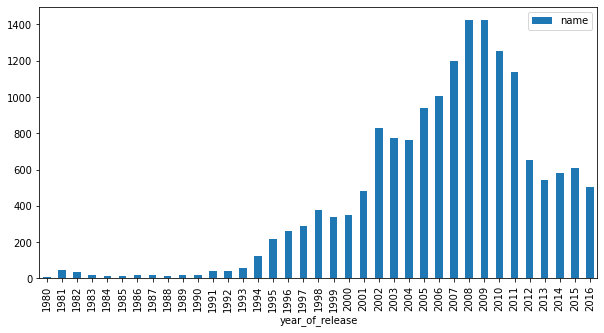

In [17]:
data_games_in_year.plot(kind='bar', 
                        x='year_of_release', 
                        y='name',
                        figsize=(10, 5)
                       )

В 2002 производство игр увеличилось в 2 раза. Пик производства пришелся на 2008, 2009 года. В 2012 производство начало падать.

Выберем платформы с наибольшими суммарными продажами и построим распределение по годам:

In [18]:
data_platforms = data.pivot_table(index='platform', values='sum_sales', aggfunc='sum').reset_index()
data_platforms.sort_values(by='sum_sales',ascending=False).head(5)


,platform,sum_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78


In [19]:
data_top_platforms = data[data['platform'].isin(['PS2', 'X360', 'Wii', 'PS3', 'DS'])]
data_top_platforms['platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', 'PS2'], dtype=object)

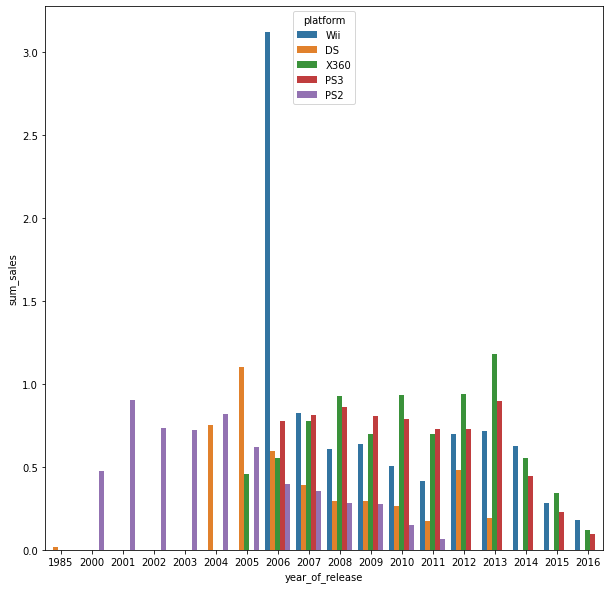

In [20]:
plt.rcParams['figure.figsize']=(10,10)
sns.barplot(data=data_top_platforms, x='year_of_release', y='sum_sales', hue='platform', ci=None)
plt.show()

Примерно раз в 5 лет появляются новые платформы, и исчезают старые.

Благодаря графикам, возьмем данные за соответствующий актуальный период:

In [21]:
new_data = data.loc[data['year_of_release'].isin([2012, 2013, 2014, 2015, 2016])]
new_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,no_rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,no_rating,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16432,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,no_rating,0.01
16436,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,no_rating,0.01
16439,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,no_rating,0.01
16441,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,no_rating,0.01


Проверим новый датасет на пропуски:

In [22]:
new_data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       1574
user_score         1355
rating                0
sum_sales             0
dtype: int64

Проверим, какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ:

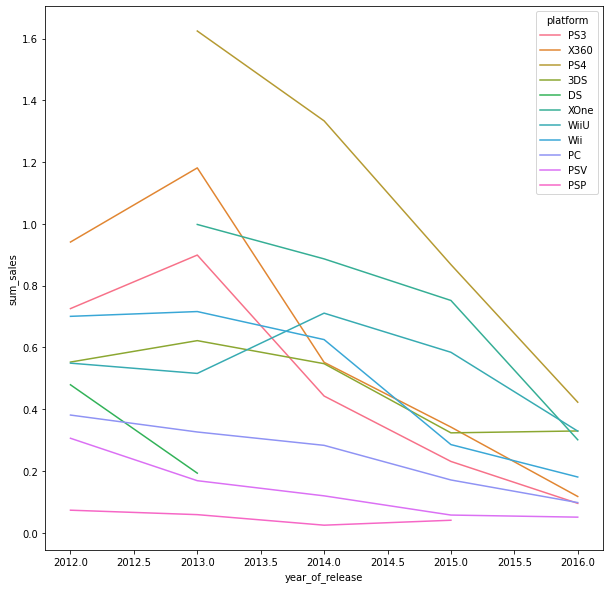

In [23]:
sns.lineplot(data=new_data, x='year_of_release', y='sum_sales', hue='platform', ci=None)
rcParams['figure.figsize'] = 15, 10
plt.show()

Лидируют по продажам PS4 и XBox One. Продажи консолей более старых поколений, таких как PSP, Wii падают. Копии игр таких платформ как PSP и вовсе перестали продаваться.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам:

<AxesSubplot:xlabel='platform', ylabel='sum_sales'>

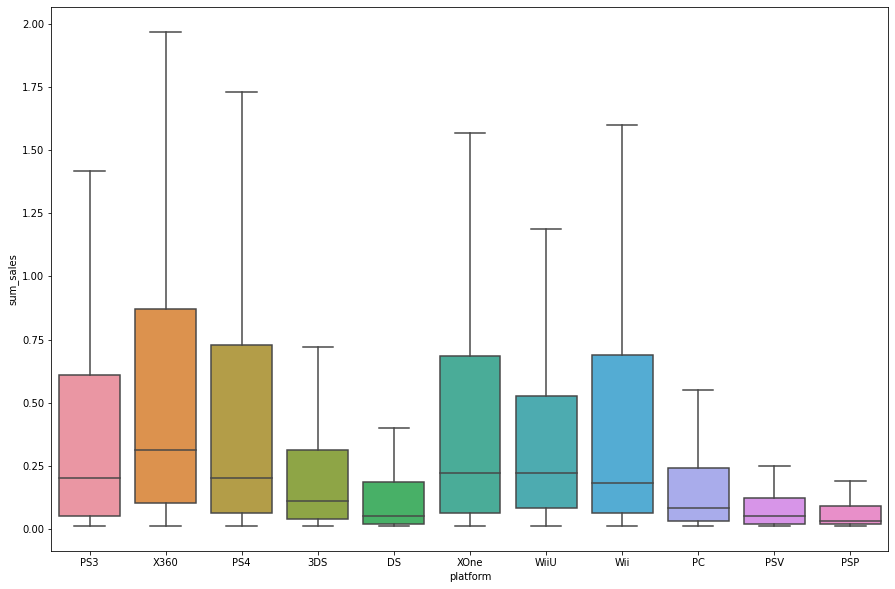

In [24]:
sns.boxplot(data=new_data, x='platform', y='sum_sales', showfliers=False)

<AxesSubplot:xlabel='platform', ylabel='sum_sales'>

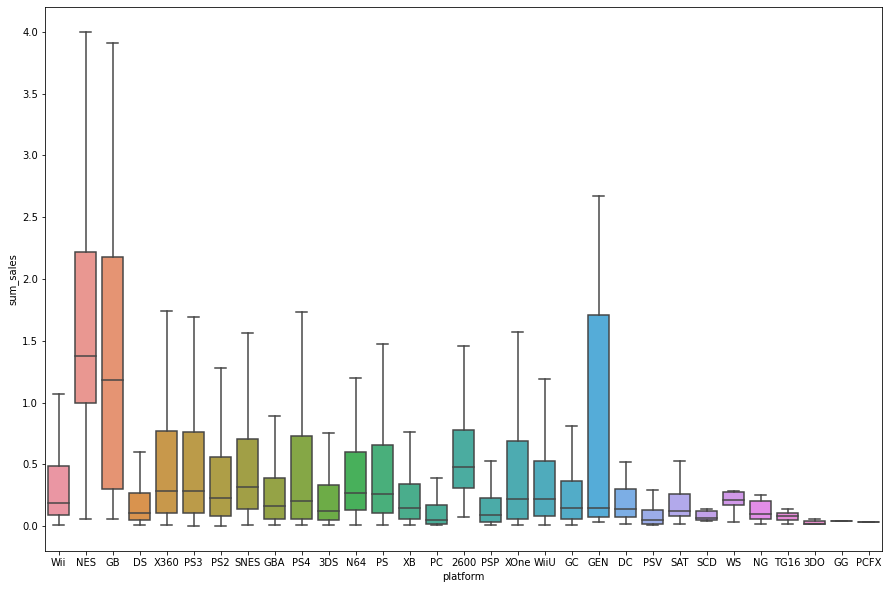

In [25]:
sns.boxplot(data=data, x='platform', y='sum_sales', showfliers=False)

Медианные продажи таких консолей, как PS4 и XOne выше остальных платформ. Менее популярны их более старые поколения X360 и PS3. 

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами:

In [26]:
ps_data = new_data.query('platform == "PS3"')

<AxesSubplot:xlabel='critic_score'>

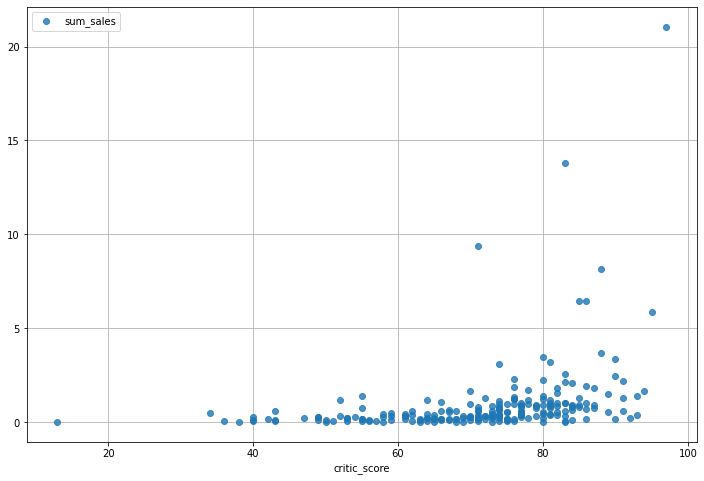

In [27]:
ps_data.plot(x='critic_score', 
              y='sum_sales', 
              grid=True,
              alpha=0.8,
              style='o', 
              figsize=(12, 8)
)

<AxesSubplot:xlabel='user_score'>

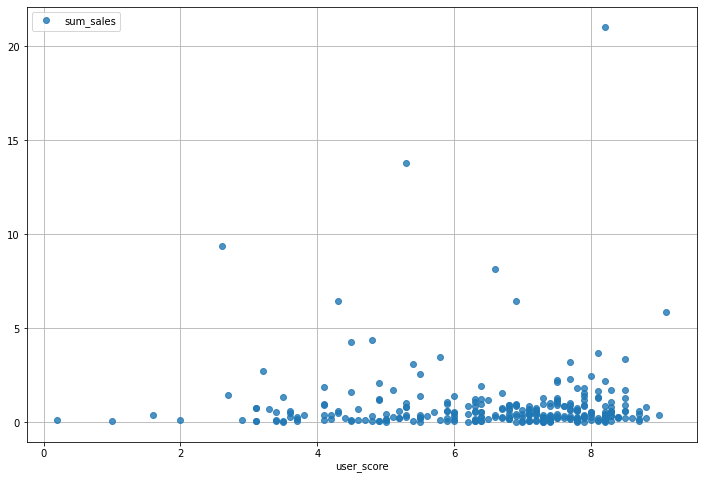

In [28]:
ps_data.plot(x='user_score', 
              y='sum_sales', 
              grid=True,
              alpha=0.8,
              style='o', 
              figsize=(12, 8)
)

In [29]:
ps_data['user_score'].corr(ps_data['sum_sales'])

-0.005143522887113828

In [30]:
ps_data['critic_score'].corr(ps_data['sum_sales'])

0.3314972592629587

По получившимся графикам и значениям, можно сказать, что продажи более зависят от отзывов критиков, чем от оценок игроков.

Соотнесем выводы с продажами игр на других платформах. Для этого создадим циклы:

Корелляция между продажами и отзывами критиков платформы PS3 равна 0.3314972592629587
Корелляция между продажами и отзывами критиков платформы X360 равна 0.3605734888507336
Корелляция между продажами и отзывами критиков платформы PS4 равна 0.40656790206178095
Корелляция между продажами и отзывами критиков платформы 3DS равна 0.3208028695360785
Корелляция между продажами и отзывами критиков платформы XOne равна 0.4169983280084017
Корелляция между продажами и отзывами критиков платформы WiiU равна 0.34837976012017485
Корелляция между продажами и отзывами критиков платформы Wii равна -0.4243413011077494
Корелляция между продажами и отзывами критиков платформы PC равна 0.23724324311567915
Корелляция между продажами и отзывами критиков платформы PSV равна 0.0944878992931617


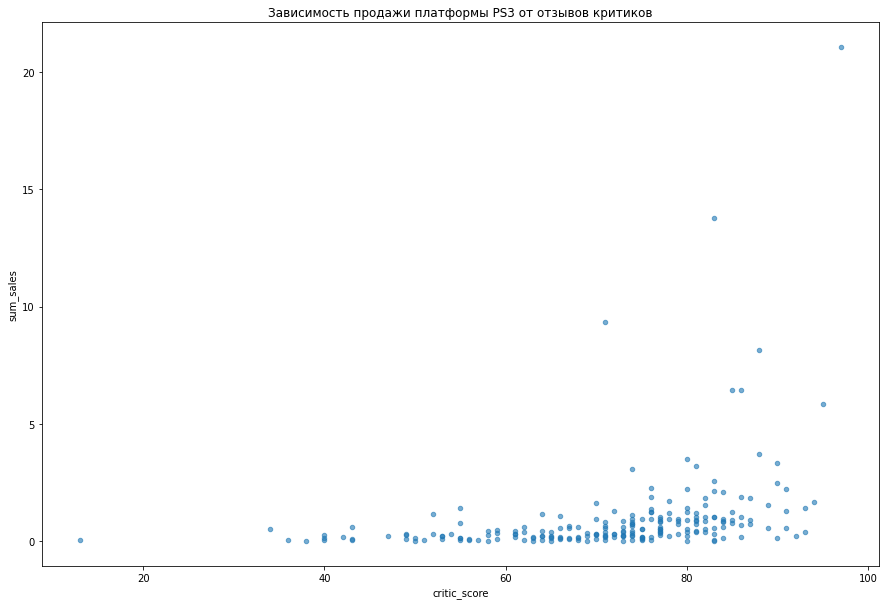

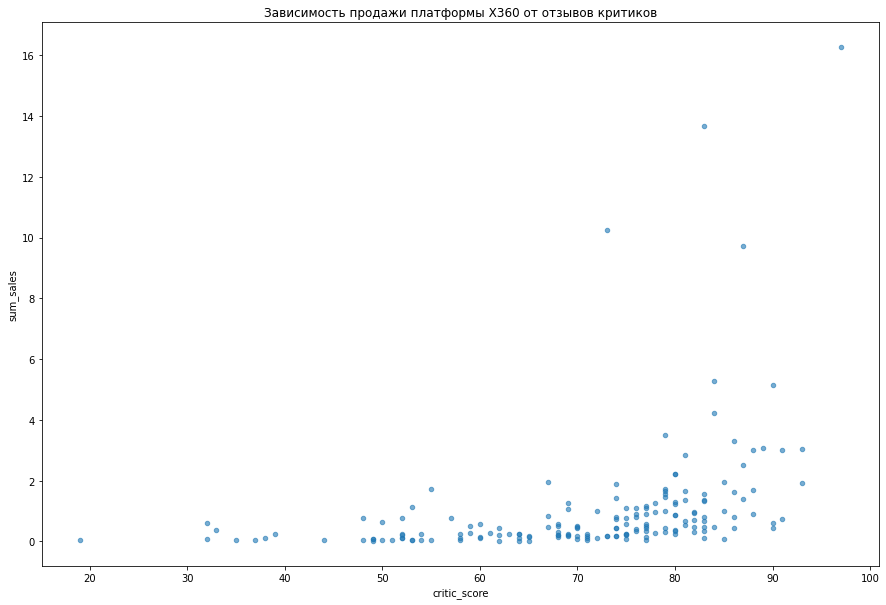

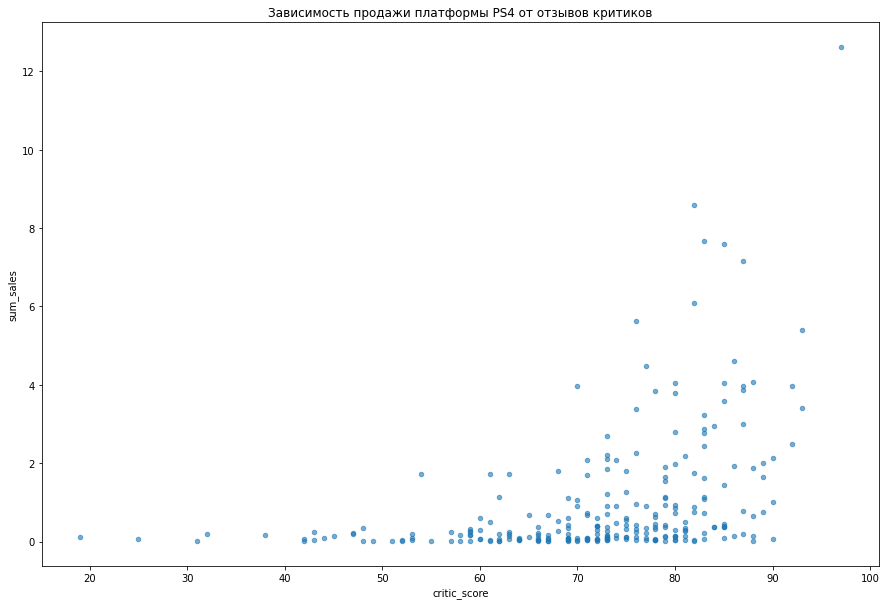

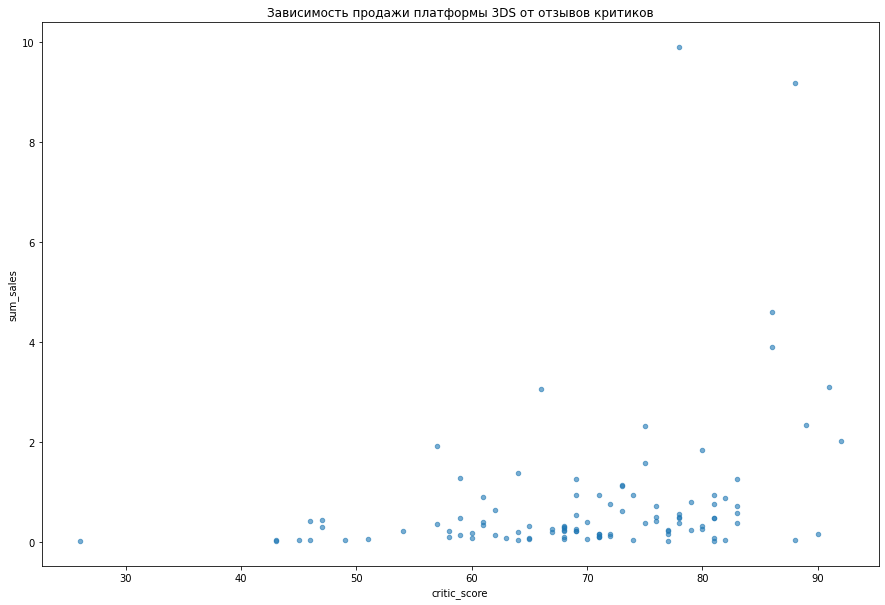

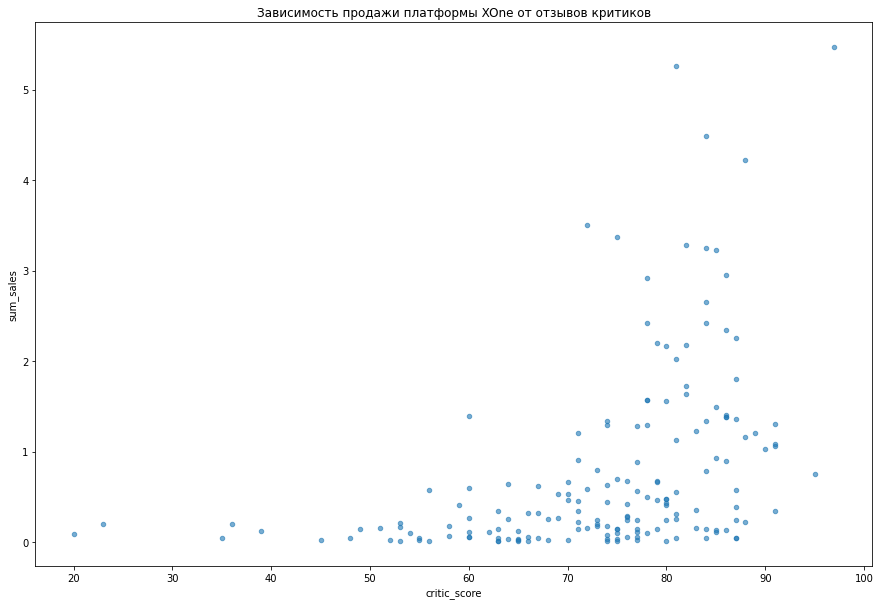

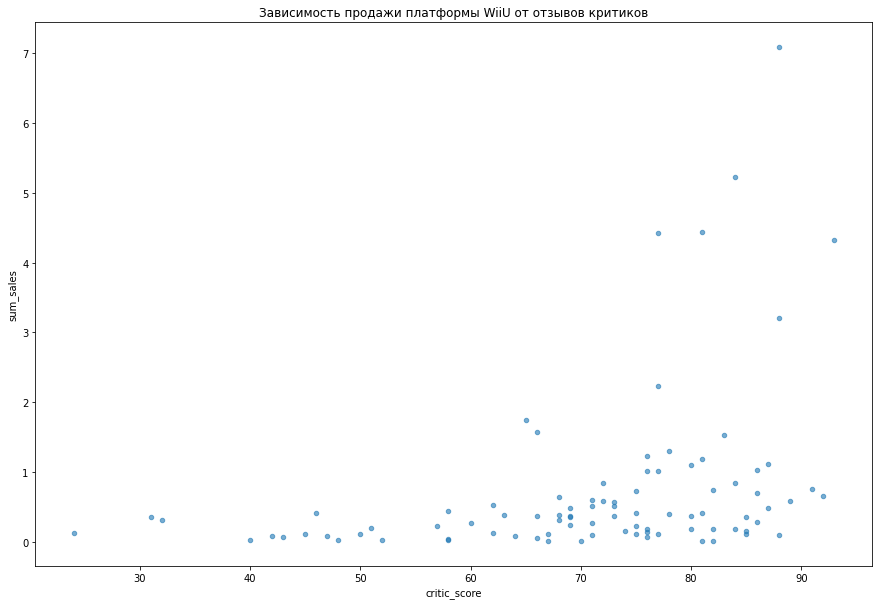

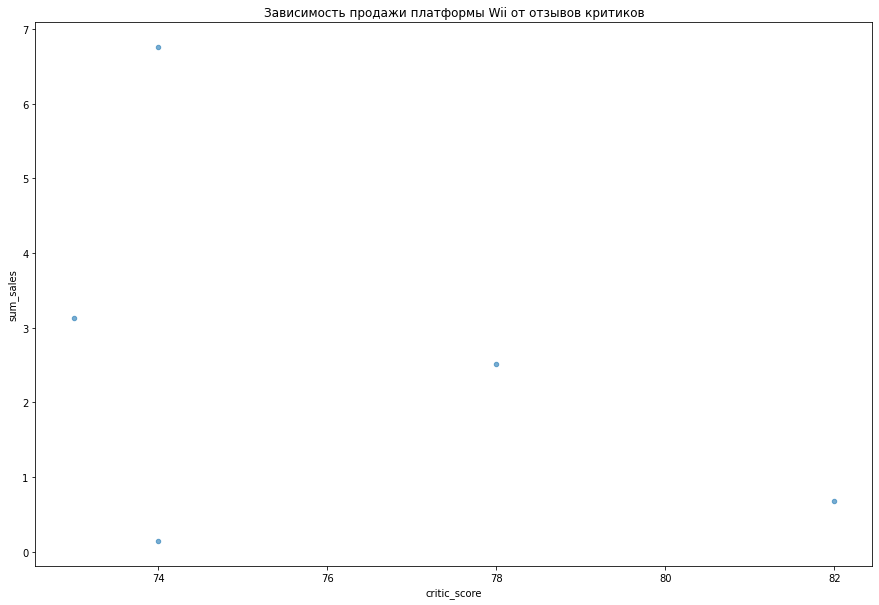

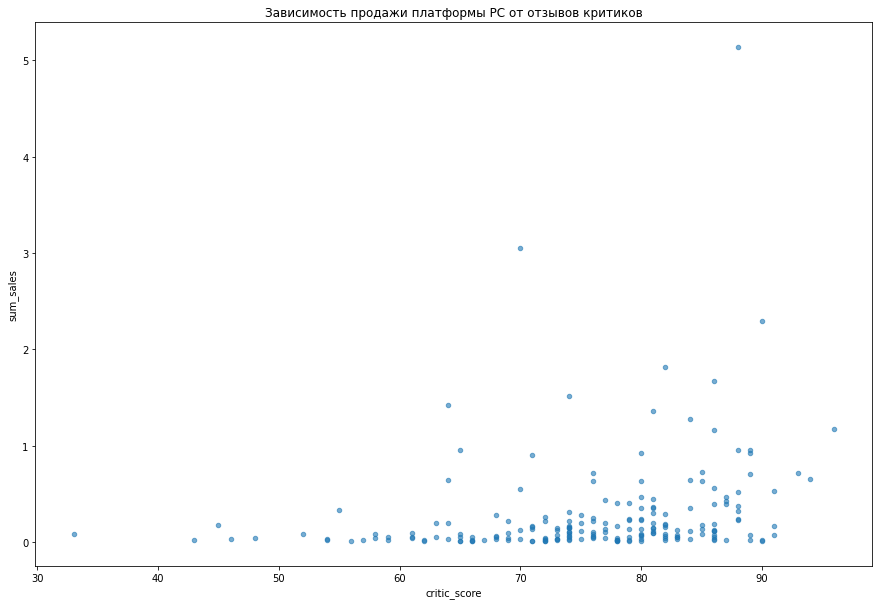

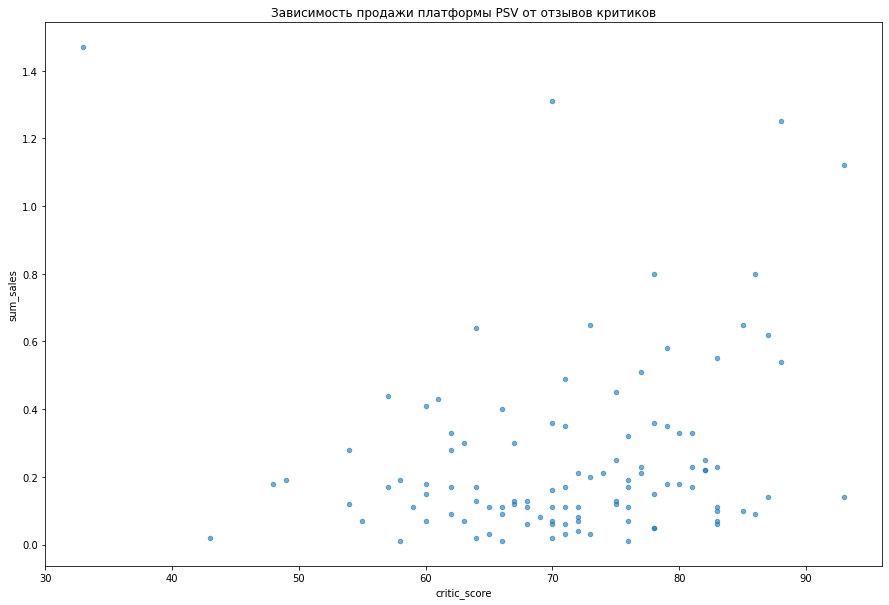

In [31]:
data_critic = new_data.query('sum_sales > 0')
list = ['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV']
for i in list:
    critic_platform = data_critic.query('platform == @i')
    critic_corr = critic_platform['critic_score'].corr(critic_platform['sum_sales'])
    print(f'Корелляция между продажами и отзывами критиков платформы {i} равна {critic_corr}')
    critic_platform.plot(kind='scatter', x='critic_score', y='sum_sales', alpha=0.6,
                        title=f'Зависимость продажи платформы {i} от отзывов критиков')

Наименьшая корелляция между продажами и отзывами критиков у платформы PSV, что является очень слабой корелляцией по шкале Чеддока. Наибольшая зависимость у платформы Wii. по шкале Чеддока это слабая зависимость.

Корелляция между продажами и отзывами игроков платформы PS3 равна -0.005143522887113828
Корелляция между продажами и отзывами игроков платформы X360 равна 0.006163978646213326
Корелляция между продажами и отзывами игроков платформы PS4 равна -0.031957110204556376
Корелляция между продажами и отзывами игроков платформы 3DS равна 0.19758263411038599
Корелляция между продажами и отзывами игроков платформы DS равна 0.88270872757644
Корелляция между продажами и отзывами игроков платформы XOne равна -0.06892505328279414
Корелляция между продажами и отзывами игроков платформы WiiU равна 0.4002190202148617
Корелляция между продажами и отзывами игроков платформы Wii равна 0.29619680007479526
Корелляция между продажами и отзывами игроков платформы PC равна -0.12186747630735577
Корелляция между продажами и отзывами игроков платформы PSV равна -0.004339437514314869


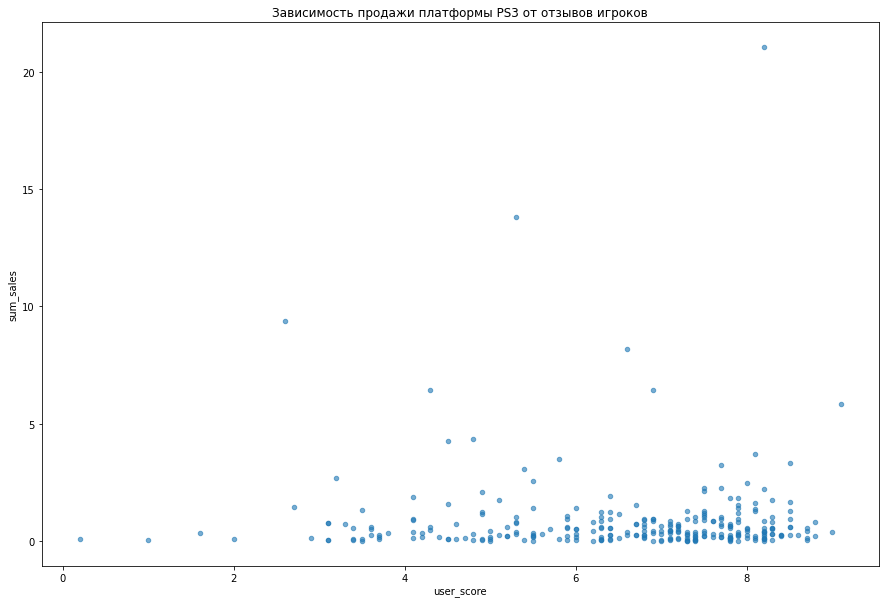

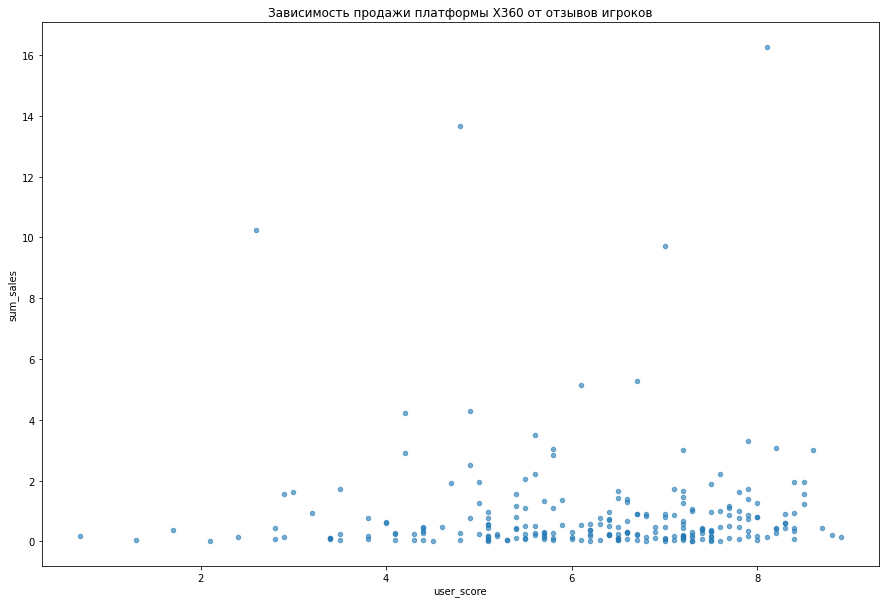

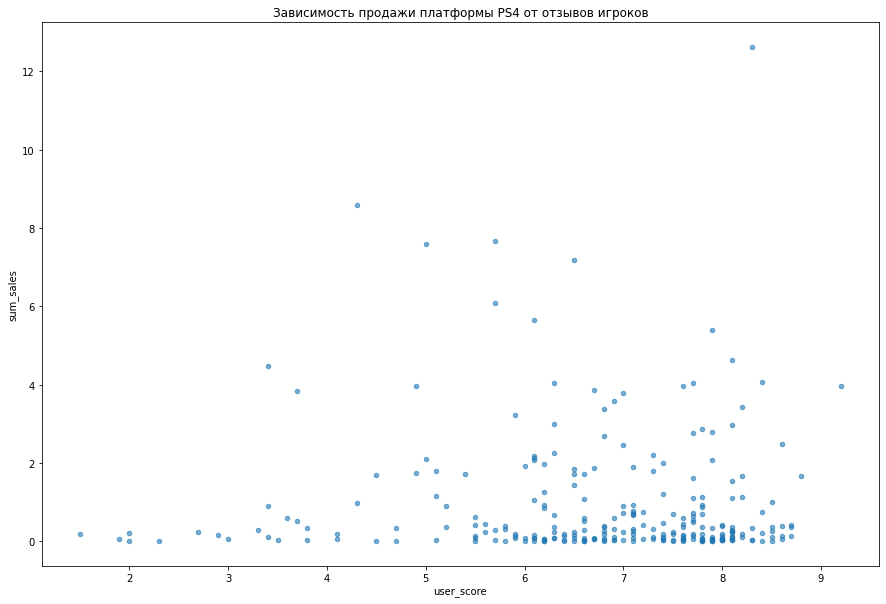

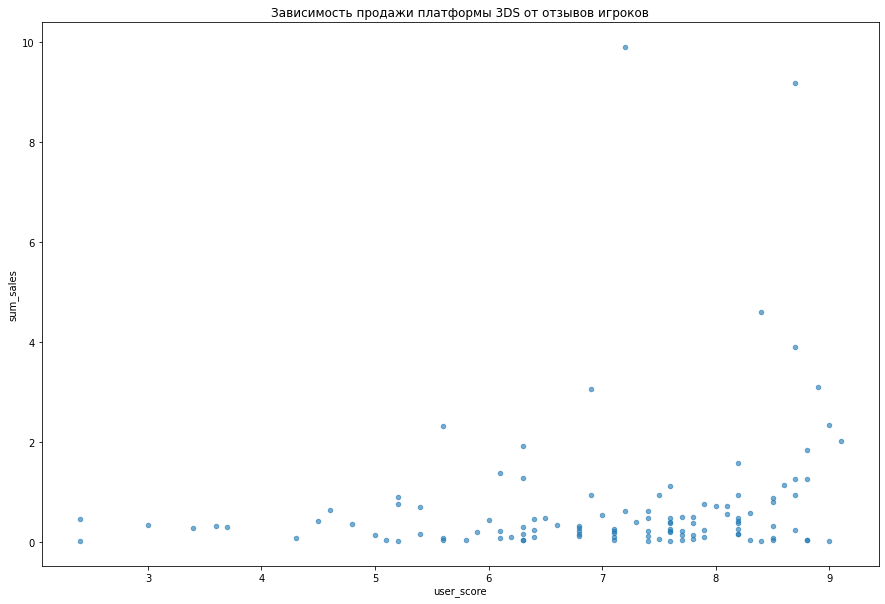

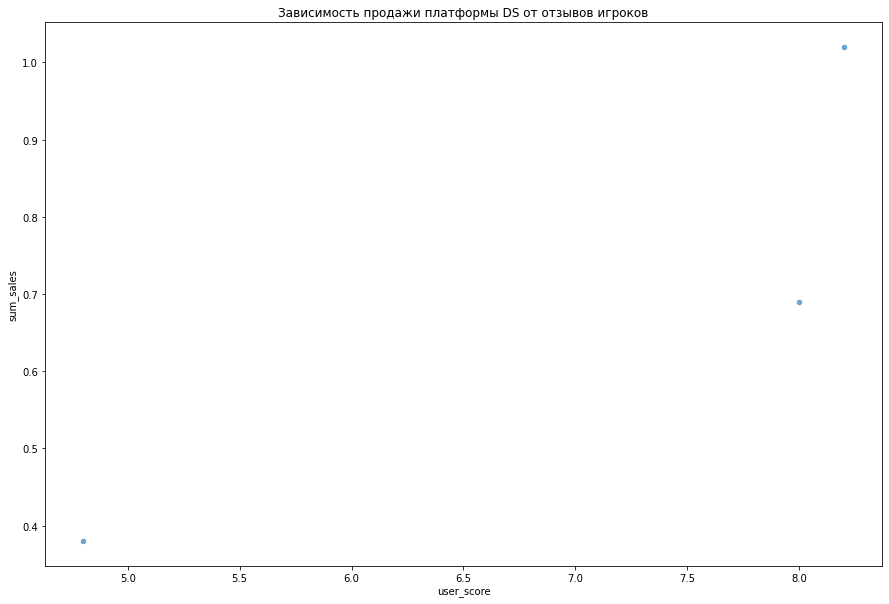

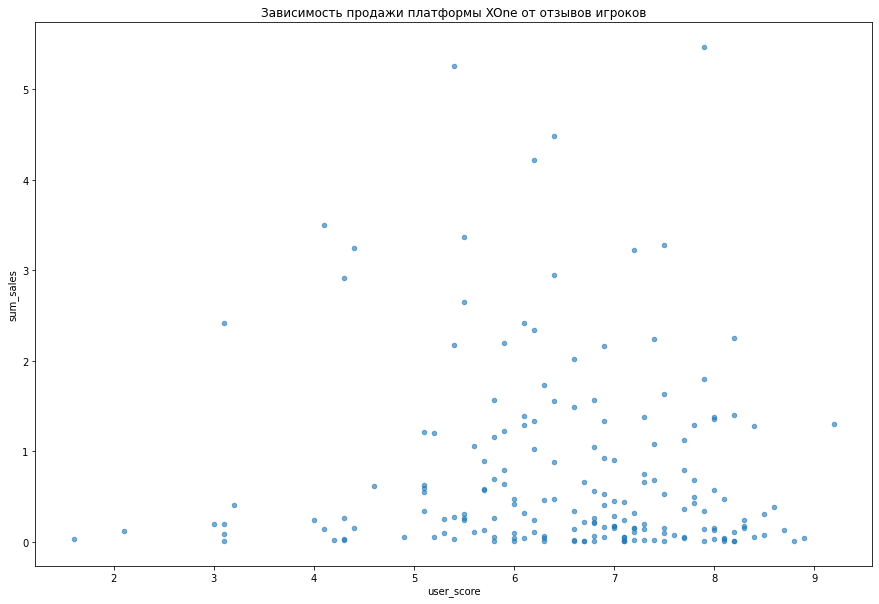

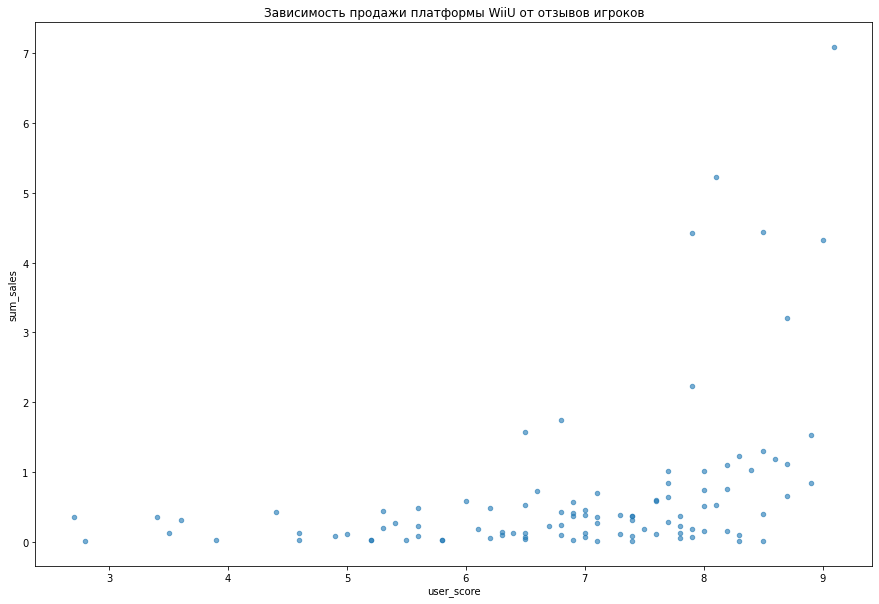

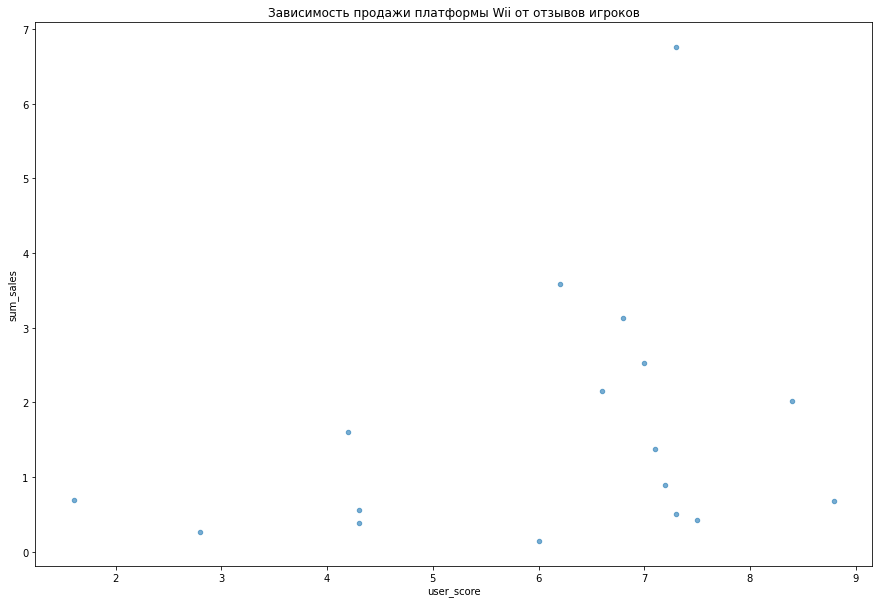

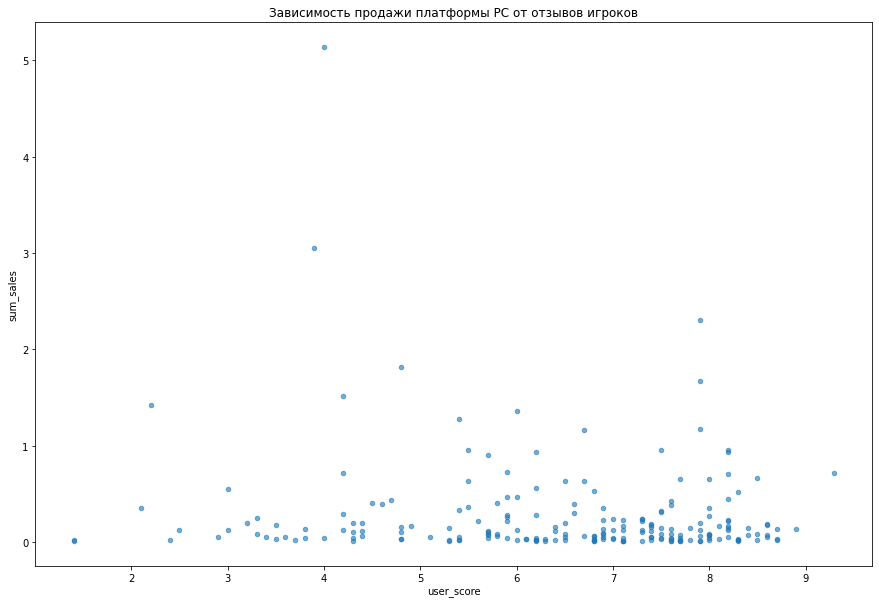

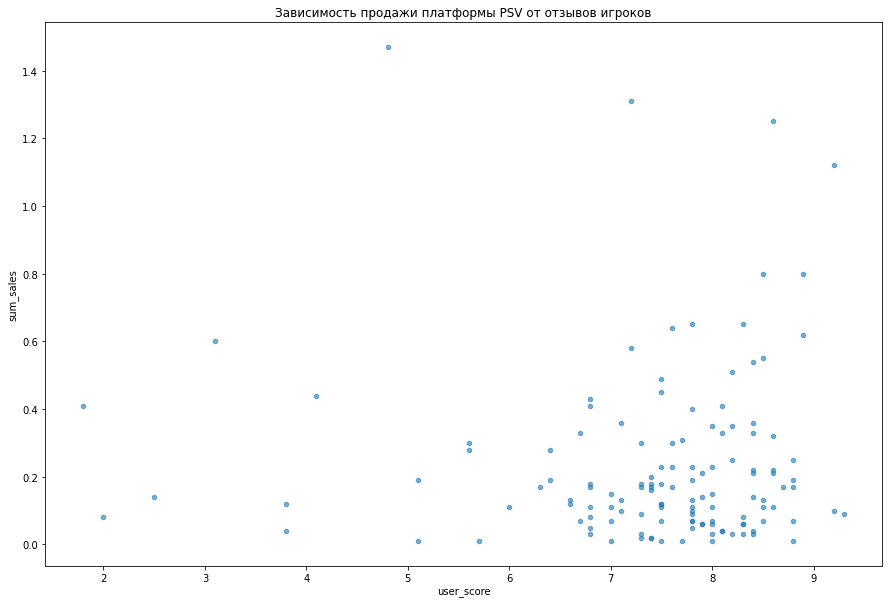

In [32]:
data_users = new_data.query('sum_sales > 0')
list = ['PS3', 'X360', 'PS4', '3DS', 'DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV']
for i in list:
    user_platform = data_users.query('platform == @i')
    user_corr = user_platform['user_score'].corr(user_platform['sum_sales'])
    print(f'Корелляция между продажами и отзывами игроков платформы {i} равна {user_corr}')
    user_platform.plot(kind='scatter', x='user_score', y='sum_sales', alpha=0.6,
                        title=f'Зависимость продажи платформы {i} от отзывов игроков')

Наибольшая корелляция между оценками игроков и продажами принадлежит платформе DS, что является высокой зависимостью. Наименьшая зависимость у PSV. По шкале Чеддока корелляция очень слабая. 

Посмотрим на общее распределение игр по жанрам:

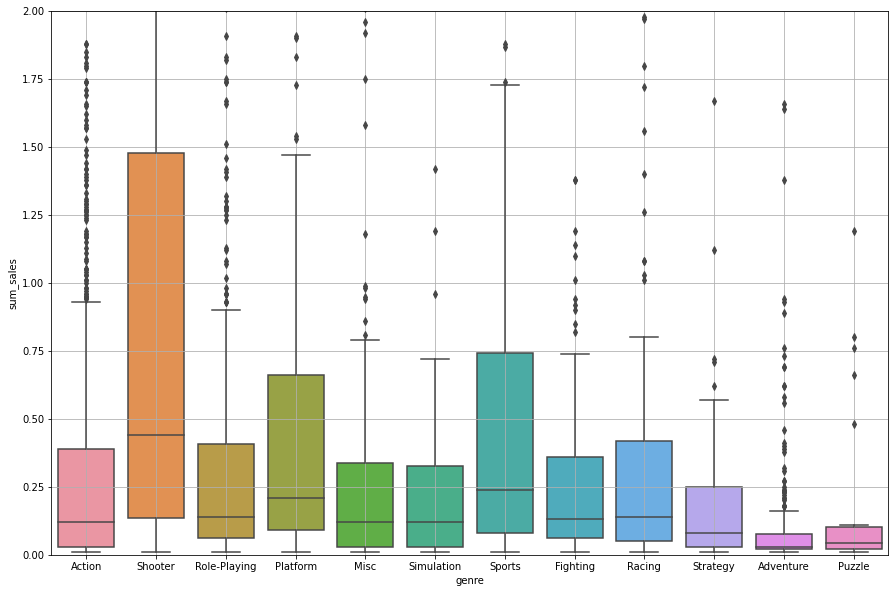

In [33]:
sns.boxplot(x=new_data['genre'], y=new_data['sum_sales'].sort_values())
plt.ylim(0,2)
plt.grid()
plt.show()

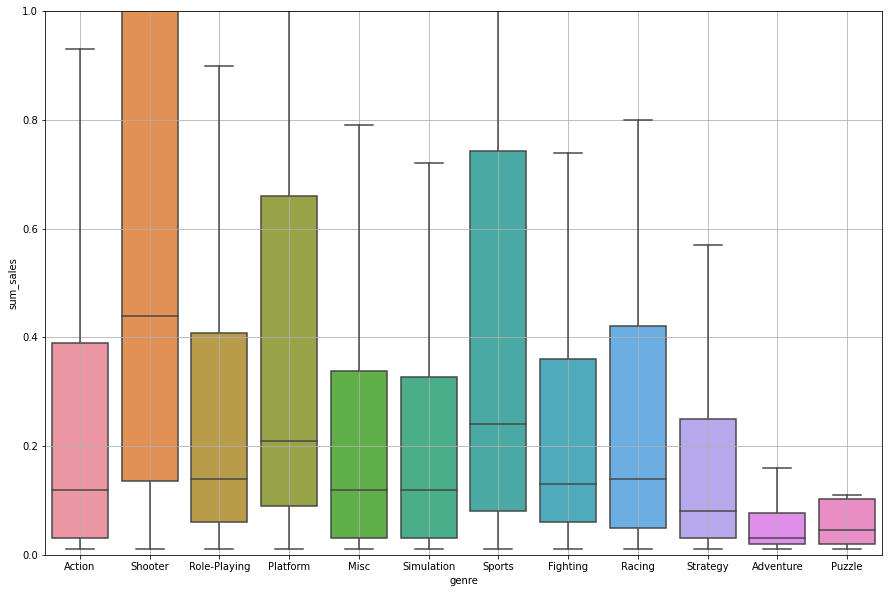

In [34]:
sns.boxplot(x=new_data['genre'], y=new_data['sum_sales'].sort_values(), showfliers=False)
plt.ylim(0,1)
plt.grid()
plt.show()

Благодаря графику, мы можем понять, что среди жанров с наибольшими продажами выделяется Shooter. За ним идет Sports. Наименьшие продажи у Adventure.

## Портрет пользователя каждого региона

Определим для пользователя каждого региона самые популрные платформы (Топ-5):

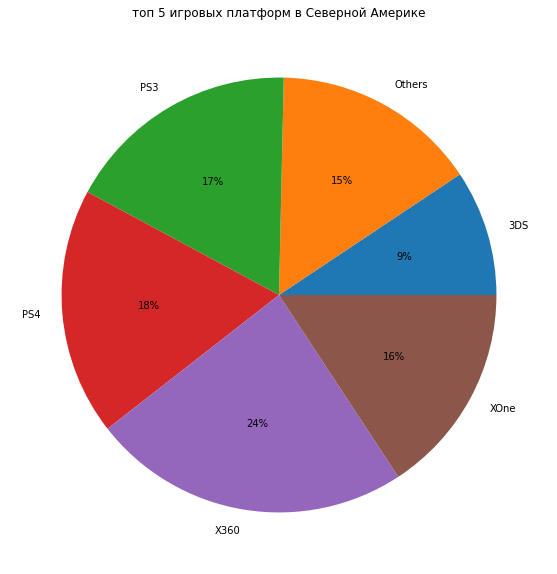

In [35]:
na_data = new_data.groupby(by='platform', as_index=False).agg({'na_sales':'sum'})
na_data = na_data.sort_values(by='na_sales', ascending=False)
na_data['platform_pie'] = na_data['platform']
na_data.iloc[5:, na_data.columns.get_loc('platform_pie')] = 'Others'
na_data = na_data.groupby(by='platform_pie', as_index=False).agg({'na_sales':'sum'})
plt.pie(data=na_data, x='na_sales', labels='platform_pie', autopct='%.0f%%');
plt.title('топ 5 игровых платформ в Северной Америке');

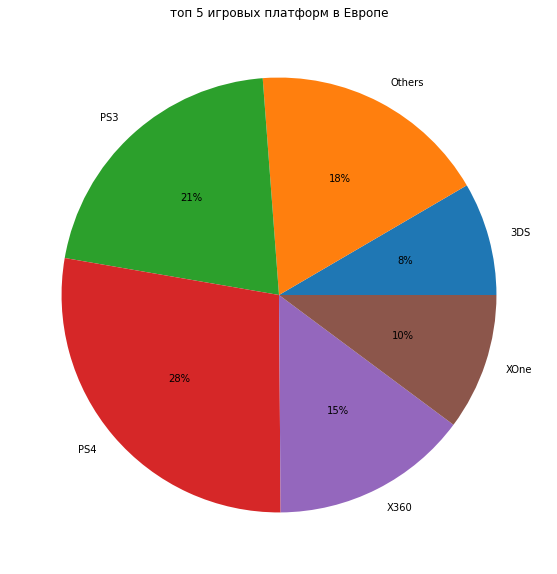

In [36]:
eu_data = new_data.groupby(by='platform', as_index=False).agg({'eu_sales':'sum'})
eu_data = eu_data.sort_values(by='eu_sales', ascending=False)
eu_data['platform_pie'] = eu_data['platform']
eu_data.iloc[5:, eu_data.columns.get_loc('platform_pie')] = 'Others'
eu_data = eu_data.groupby(by='platform_pie', as_index=False).agg({'eu_sales':'sum'})
plt.pie(data=eu_data, x='eu_sales', labels='platform_pie', autopct='%.0f%%');
plt.title('топ 5 игровых платформ в Европе');

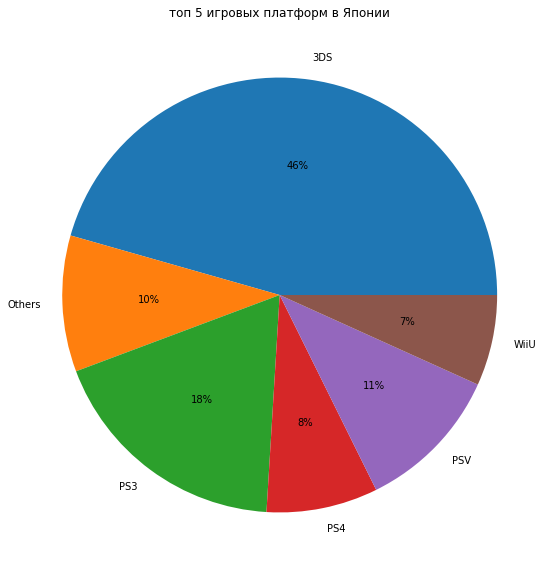

In [37]:
jp_data = new_data.groupby(by='platform', as_index=False).agg({'jp_sales':'sum'})
jp_data = jp_data.sort_values(by='jp_sales', ascending=False)
jp_data['platform_pie'] = jp_data['platform']
jp_data.iloc[5:, jp_data.columns.get_loc('platform_pie')] = 'Others'
jp_data = jp_data.groupby(by='platform_pie', as_index=False).agg({'jp_sales':'sum'})
plt.pie(data=jp_data, x='jp_sales', labels='platform_pie', autopct='%.0f%%');
plt.title('топ 5 игровых платформ в Японии');

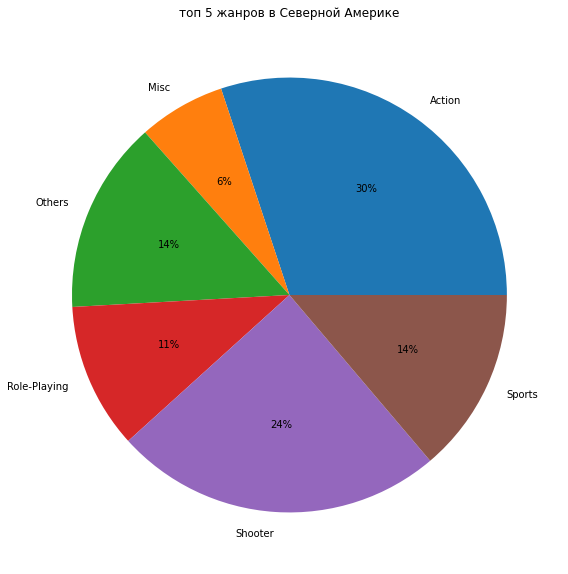

In [38]:
na_data_genre = new_data.groupby(by='genre', as_index=False).agg({'na_sales':'sum'})
na_data_genre = na_data_genre.sort_values(by='na_sales', ascending=False)
na_data_genre['genre_pie'] = na_data_genre['genre']
na_data_genre.iloc[5:, na_data_genre.columns.get_loc('genre_pie')] = 'Others'
na_data_genre = na_data_genre.groupby(by='genre_pie', as_index=False).agg({'na_sales':'sum'})
plt.pie(data=na_data_genre, x='na_sales', labels='genre_pie', autopct='%.0f%%');
plt.title('топ 5 жанров в Северной Америке');

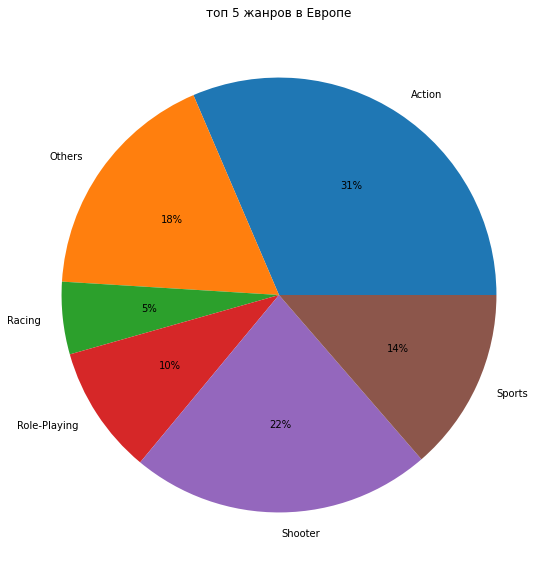

In [39]:
eu_data_genre = new_data.groupby(by='genre', as_index=False).agg({'eu_sales':'sum'})
eu_data_genre = eu_data_genre.sort_values(by='eu_sales', ascending=False)
eu_data_genre['genre_pie'] = eu_data_genre['genre']
eu_data_genre.iloc[5:, eu_data_genre.columns.get_loc('genre_pie')] = 'Others'
eu_data_genre = eu_data_genre.groupby(by='genre_pie', as_index=False).agg({'eu_sales':'sum'})
plt.pie(data=eu_data_genre, x='eu_sales', labels='genre_pie', autopct='%.0f%%');
plt.title('топ 5 жанров в Европе');

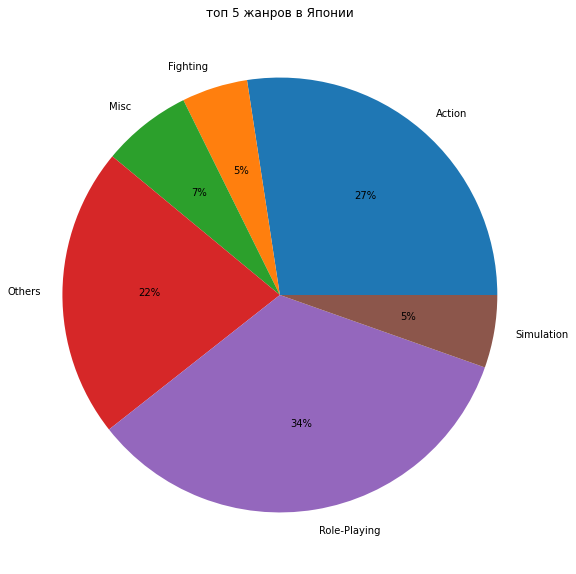

In [40]:
jp_data_genre = new_data.groupby(by='genre', as_index=False).agg({'jp_sales':'sum'})
jp_data_genre = jp_data_genre.sort_values(by='jp_sales', ascending=False)
jp_data_genre['genre_pie'] = jp_data_genre['genre']
jp_data_genre.iloc[5:, jp_data_genre.columns.get_loc('genre_pie')] = 'Others'
jp_data_genre = jp_data_genre.groupby(by='genre_pie', as_index=False).agg({'jp_sales':'sum'})
plt.pie(data=jp_data_genre, x='jp_sales', labels='genre_pie', autopct='%.0f%%');
plt.title('топ 5 жанров в Японии');

Пользователи Северной Америки чаще всего играют в такие жанры как Action и Shooter на таких платформах как PS4 и X360.
Пользователи Европы чаще играют в Action и Sgooter на платформах PS4 и ее старшим поколением PS3.
Пользователи из Японии предпочитают  Role-Playing и Action на платформах  3DS и PS3.

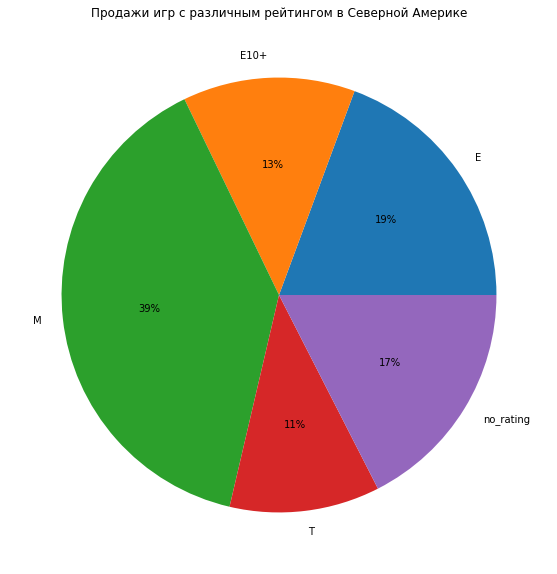

In [41]:
na_data_rating = new_data.groupby(by='rating', as_index=False).agg({'na_sales':'sum'})
na_data_rating = na_data_rating.sort_values(by='na_sales', ascending=False)
na_data_rating['rating_pie'] = na_data_rating['rating']
na_data_rating.iloc[5:, na_data_rating.columns.get_loc('rating_pie')] = 'Others'
na_data_rating = na_data_rating.groupby(by='rating_pie', as_index=False).agg({'na_sales':'sum'})
plt.pie(data=na_data_rating, x='na_sales', labels='rating_pie', autopct='%.0f%%');
plt.title('Продажи игр с различным рейтингом в Северной Америке');

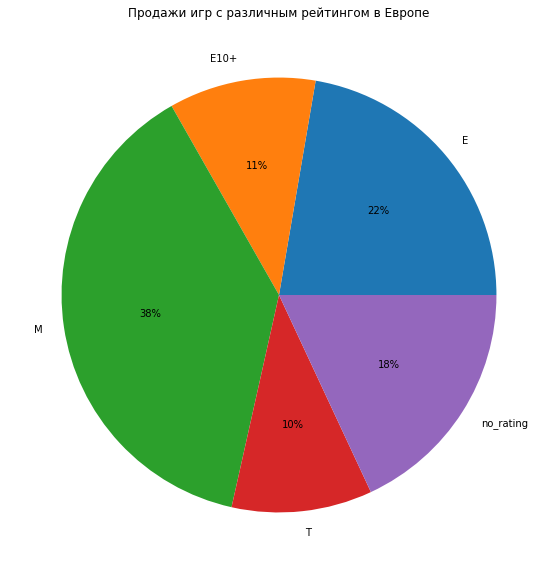

In [42]:
eu_data_rating = new_data.groupby(by='rating', as_index=False).agg({'eu_sales':'sum'})
eu_data_rating = eu_data_rating.sort_values(by='eu_sales', ascending=False)
eu_data_rating['rating_pie'] = eu_data_rating['rating']
eu_data_rating.iloc[5:, eu_data_rating.columns.get_loc('rating_pie')] = 'Others'
eu_data_rating = eu_data_rating.groupby(by='rating_pie', as_index=False).agg({'eu_sales':'sum'})
plt.pie(data=eu_data_rating, x='eu_sales', labels='rating_pie', autopct='%.0f%%');
plt.title('Продажи игр с различным рейтингом в Европе');

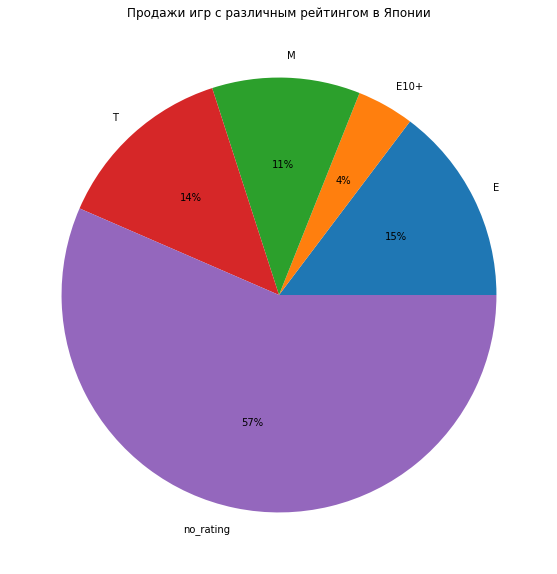

In [43]:
jp_data_rating = new_data.groupby(by='rating', as_index=False).agg({'jp_sales':'sum'})
jp_data_rating = jp_data_rating.sort_values(by='jp_sales', ascending=False)
jp_data_rating['rating_pie'] = jp_data_rating['rating']
jp_data_rating.iloc[5:, jp_data_rating.columns.get_loc('rating_pie')] = 'Others'
jp_data_rating = jp_data_rating.groupby(by='rating_pie', as_index=False).agg({'jp_sales':'sum'})
plt.pie(data=jp_data_rating, x='jp_sales', labels='rating_pie', autopct='%.0f%%');
plt.title('Продажи игр с различным рейтингом в Японии');

На графиках видно, что в Северной Америке с продажами лучше всего у игр с рейтингами Е и М. В Европе лучше продаются так же игры с рейтингом Е и М. В Японии наибольшие продажы имеют игры, рейтинги которых не определены. Следом идут игры с рейтингом E и T.

## Проверка гипотез

### Гипотеза №1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

У нас есть нулевая гипотеза Н0: средние пользовательские рейтинги платформ Xbox One и PC одинаковые, т.е. средние значения равны. Альтернативной гипотезой Н1 является: средние пользовательские рейтинги платформ Xbox One и PC не равны, т.е. средние значения не равны.

In [45]:
alpha = .05
results = st.ttest_ind(
    new_data.query('platform == "PC"')['user_score'], 
    new_data.query('platform == "XOne"')['user_score'],
    nan_policy='omit'
)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.5535080500643738
Не получилось отвергнуть нулевую гипотезу


Принимаем Альтернативную гипотезу Н1. Средние пользовательские рейтинги Xbox One и PC не равны.

### Гипотеза №2: средние пользовательские рейтинги жанров Action и Sports разные.

У нас есть нулевая гипотеза Н0: средние пользовательские рейтинги жанров Action и Sports равны., т.е. средние значения равны. Альтернативной гипотезой Н1 является: средние пользовательские рейтинги жанров Action и Sports не равны, т.е. средние значения не равны.

In [46]:
alpha = .05
results = st.ttest_ind(
    new_data.query('genre == "Action"')['user_score'], 
    new_data.query('genre == "Sports"')['user_score'],
    nan_policy='omit'
)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  3.7163089460934874e-26
Отвергаем нулевую гипотезу


Принимаем альтернативную гипотезу Н1. Средние пользовательские рейтинги жанров Action и Sports не равны.

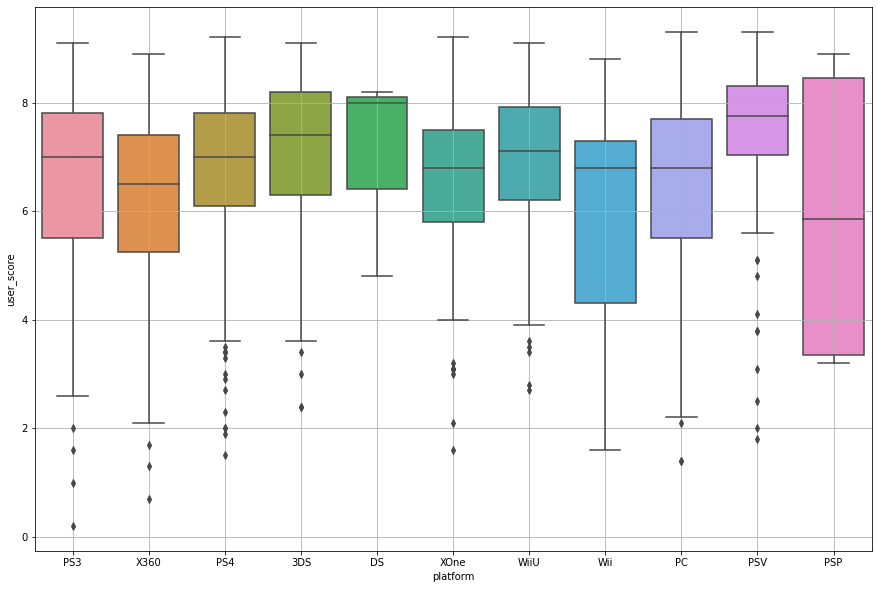

In [47]:
sns.boxplot(x=new_data['platform'], y=new_data['user_score'].sort_values())
plt.grid()
plt.show()

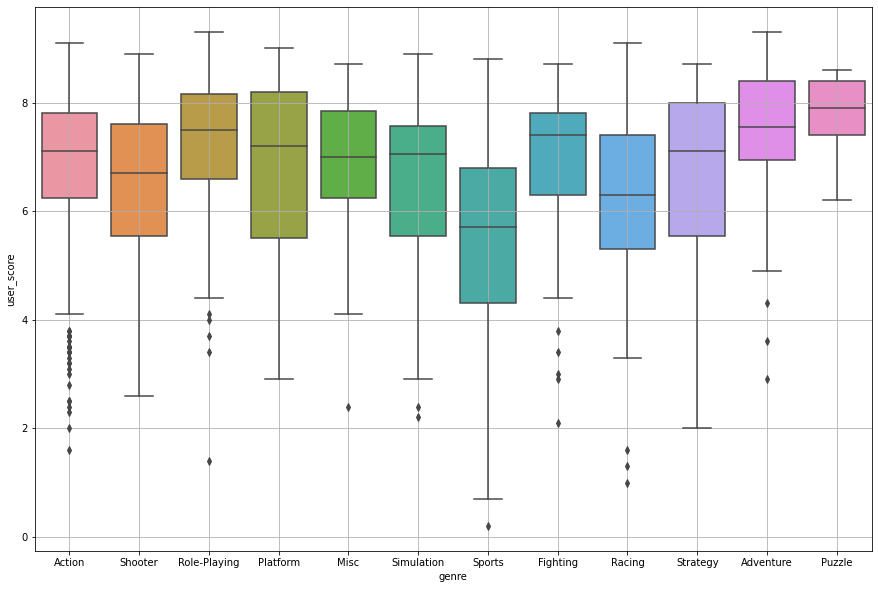

In [48]:
sns.boxplot(x=new_data['genre'], y=new_data['user_score'].sort_values())
plt.grid()
plt.show()

## Общий вывод

### Предобработка данных

При предобработке данных были исправлены названия столбцов, приведены типы данных, добавлен столбец sum_sales с суммой продаж со всех регионов. 

### Цели исследования

Целью исследования было выявить определяющие успешность игры закономерности, а именно: посмотреть, сколько игр выпускалось в разные годы, посмотреть, как менялись продажи по платформам, взять данные за соответствующий актуальный период. Затем посмотреть какие платформы лидируют по продажам, растут или падают, построить график «ящик с усами» по глобальным продажам игр в разбивке по платформам, посмотреть, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков, соотнести выводы с продажами игр на других платформах и посмотреть на общее распределение игр по жанрам. После составить портрет пользователя и проверить две гипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые, средние пользовательские рейтинги жанров Action и Sports  разные.

### Исследование

В процессе исследования были выявлены закономерности определяющте успешность игры, составлены портреты пользователя из кажого региона и проверены две гипотезы.

### Итог

Для рекламы в странах Северной Америки лучше подходят игры жанра Action и Shooter на платформах X360 и PS4. Для пользователей Европы подходят игры в жанре  Action и Sgooter на платформах PS4 и PS3. Пользователям из Японии нужны игры в жанре Role-Playing и Action на платформах 3DS и PS3. В Северной Америке с продажами лучше всего у игр с рейтингами Е и М. В Европе лучше продаются так же игры с рейтингом Е и М. В Японии наибольшие продажы имеют игры, рейтинги которых не определены. Следом идут игры с рейтингом E и T.